In [135]:
import pandas as pd
import pickle
import ast
import numpy as np
from rdkit.Chem import AllChem

# Data preparation

In [208]:
# load data
# Build a dataframe that contains all predictors and only contains fully identified cells for a start
df = pd.read_csv('data/df_all_cells_many_properties_NORTH.csv')
print(f"Raw data length: {len(df)}.")

# eliminate all cells that have non-identified htls or etls. This pickle
# was created in How_many_cells_identified.ipynb
with open('data/df_all_ctls_identified_v2.pkl', 'rb') as f:
    df_id = pickle.load(f)
print(f"Length of CTL identification info: {len(df_id)}.")

# add the both_identified column to df and only keep the fully identified cells
df['both_identified'] = df_id['both_identified']
df_all_identified = df[df['both_identified'] == True]
print(f"After keeping only fully identified CTLs: {len(df_all_identified)}.")

# drop cells without a device stack information (306)
df_all_identified['device_stack'].apply(ast.literal_eval)
df_all_identified = df_all_identified.dropna(subset=['device_stack'])
print(f"After dropping NAs in device stack: {len(df_all_identified)}.")

# drop cells without reduced_formulas
df_all_identified = df_all_identified[df_all_identified['reduced_formulas'] != "None"]
print(f"After dropping None strings in reduced_formulas: {len(df_all_identified)}.")

df_all_identified = df_all_identified.dropna(subset=['reduced_formulas'])
print(f"After dropping NAs in reduced_formulas: {len(df_all_identified)}.")

# eliminate cells that were measured at an illumination intensity other than 1000 W/m^2
df_all_identified['ill_int'] = pd.to_numeric(df_all_identified['ill_int'], errors='coerce')
df_all_identified = df_all_identified[df_all_identified['ill_int'] == 1000]
print(f"After dropping cells that were measured at illumination intensity other than 1000 W/m^2: {len(df_all_identified)}.")

# eliminate rows with large device areas
df_all_identified['device_area'] = pd.to_numeric(df_all_identified['device_area'], errors='coerce')
df_all_identified = df_all_identified[df_all_identified['device_area'] <= 0.000025]
print(f"After dropping cells with device area greater than 25 mm^2: {len(df_all_identified)}.")


# drop everything that is not further needed
df_all_identified = df_all_identified.drop(columns=['voc', 
                                                    'jsc', 
                                                    'ff', 
                                                    'structural_dimensionality', 
                                                    'both_identified', 
                                                    'device_stack',
                                                    'ill_int',
                                                    'device_area',
                                                   ])

# transform etl and htl to lists
df_all_identified['etl'] = df_all_identified['etl'].apply(ast.literal_eval)
df_all_identified['htl'] = df_all_identified['htl'].apply(ast.literal_eval)


# split entries separated with semicolons into proper comma separated lists
for index, _ in df_all_identified.iterrows():
    i = 0
    while i < len(df_all_identified.at[index, "etl"]):
        if ";" in df_all_identified.at[index, "etl"][i]:
            elements = df_all_identified.at[index, "etl"][i].split(";")
            df_all_identified.at[index, "etl"] = df_all_identified.at[index, "etl"][:i] + elements + df_all_identified.at[index, "etl"][i+1:]
        i += 1

for index, _ in df_all_identified.iterrows():
    i = 0
    while i < len(df_all_identified.at[index, "htl"]):
        if ";" in df_all_identified.at[index, "htl"][i]:
            elements = df_all_identified.at[index, "htl"][i].split(";")
            df_all_identified.at[index, "htl"] = df_all_identified.at[index, "htl"][:i] + elements + df_all_identified.at[index, "htl"][i+1:]
        i += 1
        
# transform pce to numeric
df_all_identified['pce'] = pd.to_numeric(df_all_identified['pce'], errors='coerce')
df_all_identified = df_all_identified.dropna(subset=['pce'])
print(f"After dropping cells without pce information: {len(df_all_identified)}.")

# transform bandgaps to proper size values, transforming nones into zeros
df_all_identified['bandgap'] = pd.to_numeric(df_all_identified['bandgap'], errors='coerce')
# check how many bandgaps are none
df_check = df_all_identified.dropna(subset=['bandgap'])
print(f"How many nones in bandgap: {len(df_all_identified)-len(df_check)}")
df_all_identified['bandgap'] = df_all_identified['bandgap'].fillna(0)
df_all_identified['bandgap'] = df_all_identified['bandgap']*6.24150974e18

df_all_identified['etl_key'] = df_all_identified['etl'].apply(lambda x: ';'.join(x))
df_all_identified['htl_key'] = df_all_identified['htl'].apply(lambda x: ';'.join(x))
df_all_identified['bandgap_key'] = df_all_identified['bandgap'].round(decimals=4)

df_all_identified = df_all_identified.groupby(['reduced_formulas', 'etl_key', 'htl_key', 'bandgap_key']).agg({
                       'reduced_formulas': 'first',
                       'etl': 'first',
                       'htl': 'first',
                       'bandgap': 'mean',
                       # 'device_stack': 'first',
                       'pce': 'mean',
                      }).reset_index(drop=True)

df_all_identified

Raw data length: 43108.
Length of CTL identification info: 43108.
After keeping only fully identified CTLs: 37633.
After dropping NAs in device stack: 37633.
After dropping None strings in reduced_formulas: 37081.
After dropping NAs in reduced_formulas: 37081.
After dropping cells that were measured at illumination intensity other than 1000 W/m^2: 36662.
After dropping cells with device area greater than 25 mm^2: 34005.
After dropping cells without pce information: 33286.
How many nones in bandgap: 7875


,reduced_formulas,etl,htl,bandgap,pce
0,Ag10Bi10Br57Cs20,"[TiO2-c, TiO2-mp]",[Spiro-MeOTAD],0.00,1.600
1,Ag10Bi10Br59Cs20,"[TiO2-c, TiO2-mp]",[Spiro-MeOTAD],0.00,1.400
2,Ag10Bi10Br60Cs17Rb3,[SnO2-np],[Spiro-MeOTAD],0.00,0.850
3,Ag10Bi10Br60Cs19Rb,[SnO2-np],[Spiro-MeOTAD],0.00,1.270
4,Ag20Bi20CsI60,"[TiO2-c, TiO2-mp]",[P3HT],1.86,3.530
...,...,...,...,...,...
5817,I9K3Sb2,"[TiO2-c, TiO2-mp]",[Spiro-MeOTAD],2.02,0.070
5818,I9Rb3Sb2,"[TiO2-c, TiO2-mp]",[PolyTPD],2.24,0.335
5819,I9Rb3Sb2,"[TiO2-c, TiO2-mp]",[Spiro-MeOTAD],2.03,0.760
5820,LaS3Y,[CdS],[none],2.00,0.000


## Create SMILES dict

In [209]:
# SKIP THIS IF larger_SMILES_dictionary ALREADY EXISTS
# Transform the dictionary entries to SMILES
import requests

try:
    with open('data/larger_SMILES_dict.pkl', 'rb') as f:
        larger_SMILES_dict = pickle.load(f)
except:
    with open('data/dict_device_stack_materials.pkl', 'rb') as f:
        ds_dict = pickle.load(f)
    
    def CID_to_SMILES(CID):
        '''
        This searches for a CTL material's CID in PubChem.
        Argument: industry_name (str) - the name of the material
        Value: CID (int) - the CID of the material
        '''
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{CID}/property/CanonicalSMILES/JSON"
        
        response = requests.get(url)
    
        if response.status_code == 200:
            data = response.json()
            data = data['PropertyTable']['Properties'][0]['CanonicalSMILES']
            return data
        else:
            print('debug: SMILES could not be retrieved')
            raise Exception(f"Error: Could not retrieve SMILES from this CID. Status code: {response.status_code}")
            return None
    
    #initialize new dictionary where the SMILES will be written
    larger_SMILES_dict = {}
    
    # populate the SMILES dictionary
    for index, name in enumerate(ds_dict):
        print(f"{index+1}/2559. Next up: {name}")
        CID = ds_dict[name]
        if CID is not None:
            SMILES = CID_to_SMILES(CID)
            larger_SMILES_dict[name] = SMILES
        else:
            larger_SMILES_dict[name] = None
    
    with open('data/larger_SMILES_dict.pkl', 'wb') as f:
        pickle.dump(larger_SMILES_dict, f)

## Write SMILES into dataframe

In [210]:
# Write SMILES into the dataframe
df_all_identified['pce'] = df_all_identified['pce'].astype(float)

# the SMILES_dict contains no entry for "no ctl" yet
larger_SMILES_dict['none'] = "no_ctl"

for index, row in df_all_identified.iterrows():
    etl_SMILES = []
    for element in row['etl']:
        etl_SMILES.append(larger_SMILES_dict[element])
    df_all_identified.loc[index, 'etl_SMILES'] = str(etl_SMILES)
    htl_SMILES = []
    for element in row['htl']:
        htl_SMILES.append(larger_SMILES_dict[element])
    df_all_identified.loc[index, 'htl_SMILES'] = str(htl_SMILES)

# output of the function are strings, so we transform to lists
df_all_identified['etl_SMILES'] = df_all_identified['etl_SMILES'].apply(ast.literal_eval)
df_all_identified['htl_SMILES'] = df_all_identified['htl_SMILES'].apply(ast.literal_eval)

# drop rows where the etl_SMILES or the htl_SMILES contain None
def has_all_non_none_elements(data_list):
  """Checks if all elements in a list are not None."""
  return all(element is not None for element in data_list)

# Filter rows where any element in etl_SMILES or htl_SMILES is None
print(len(df_all_identified))
df_all_identified = df_all_identified[df_all_identified['etl_SMILES'].apply(has_all_non_none_elements) &
                                 df_all_identified['htl_SMILES'].apply(has_all_non_none_elements)]
print(len(df_all_identified))

5822
5818


# Combine SMILES into one string where there are multiple

In [211]:
etl_combined_SMILES = []
htl_combined_SMILES = []

for index, row in df_all_identified.iterrows():
    etl_combination = ".".join(row['etl_SMILES'])
    htl_combination = ".".join(row['htl_SMILES'])
    etl_combined_SMILES.append(etl_combination)
    htl_combined_SMILES.append(htl_combination)
df_all_identified['etl_combined_SMILES'] = etl_combined_SMILES
df_all_identified['htl_combined_SMILES'] = htl_combined_SMILES

df_all_identified['etl_combined_SMILES'] = df_all_identified['etl_combined_SMILES'].str.replace('no_ctl', '')
df_all_identified['htl_combined_SMILES'] = df_all_identified['htl_combined_SMILES'].str.replace('no_ctl', '')


/tmp/ipykernel_1647477/620127650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_identified['etl_combined_SMILES'] = etl_combined_SMILES
/tmp/ipykernel_1647477/620127650.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_identified['htl_combined_SMILES'] = htl_combined_SMILES
/tmp/ipykernel_1647477/620127650.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [206]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator
import numpy as np
import re
from rdkit import DataStructs

fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)

def parse_formula(formula):
    matches = re.findall(r'([A-Z][a-z]?)(\d*)', formula)
    element_counts = {}
    for (element, count) in matches:
        if element in element_counts:
            element_counts[element] += int(count) if count else 1
        else:
            element_counts[element] = int(count) if count else 1
    return element_counts

# Unique elements across all formulas
ELEMENTS = ['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'B', 'Li', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ti', 'V', 
            'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Ru', 'Rh', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 
            'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Th', 'U']

# Create columns for each element count
for element in ELEMENTS:
    df_all_identified[element] = df_all_identified['reduced_formulas'].apply(lambda x: parse_formula(x).get(element, 0))

def smiles_to_fingerprint(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return np.zeros(fpgen.GetNumBits(),)
    fp = fpgen.GetFingerprint(molecule)
    # Convert to a bit vector
    bit_vector = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, bit_vector)
    return bit_vector

# Create columns for Morgan Fingerprints
etl_fingerprints = df_all_identified['etl_combined_SMILES'].apply(smiles_to_fingerprint)
htl_fingerprints = df_all_identified['htl_combined_SMILES'].apply(smiles_to_fingerprint)

# Convert fingerprints to DataFrame
etl_fingerprint_df = pd.DataFrame(etl_fingerprints.tolist(), columns=[f'ETL_FP_{i}' for i in range(1024)])
htl_fingerprint_df = pd.DataFrame(htl_fingerprints.tolist(), columns=[f'HTL_FP_{i}' for i in range(1024)])

# Combine all features into a single DataFrame
features_df = pd.DataFrame
features_df = pd.concat([df_all_identified.drop(columns=['reduced_formulas',
                                                         'etl', 
                                                         'htl', 
                                                         'etl_SMILES',
                                                         'htl_SMILES',
                                                         'etl_combined_SMILES',
                                                         'htl_combined_SMILES']), etl_fingerprint_df, htl_fingerprint_df], axis=1)

print(len(features_df))
features_df = features_df.dropna()
print(len(features_df))

#features_df

/tmp/ipykernel_1647477/385860224.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_identified[element] = df_all_identified['reduced_formulas'].apply(lambda x: parse_formula(x).get(element, 0))
[13:40:56] WARNING: not removing hydrogen atom without neighbors
[13:41:14] WARNING: not removing hydrogen atom without neighbors
[13:41:14] WARNING: not removing hydrogen atom without neighbors


5822
5814


In [201]:
features_df.to_csv('data/df_fingerprints.csv', index=False)

# Machine Learning

First trying Gradient Boosting from scikit learn.

In [176]:
from sklearn.model_selection import train_test_split

X = features_df.drop(columns=['pce'])
y = features_df['pce']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape, y.shape) # shape should be e.g. 43000, num_of_features

(5814, 2125) (5814,)


In [177]:
# gradient boosting for regression in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

# evaluate the model
model = GradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# fit the model on the whole dataset
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

MAE: -3.085 (0.140)


GradientBoostingRegressor()

In [179]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")


Mean Absolute Error (MAE): 3.012
Mean Squared Error (MSE): 15.121
R^2 Score: 0.542


In [146]:
# xgboost for regression
from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

# evaluate the model
model = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# fit the model on the whole dataset
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)


MAE: -2.960 (0.143)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [147]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error (MAE): 2.926
Mean Squared Error (MSE): 14.945
R^2 Score: 0.547


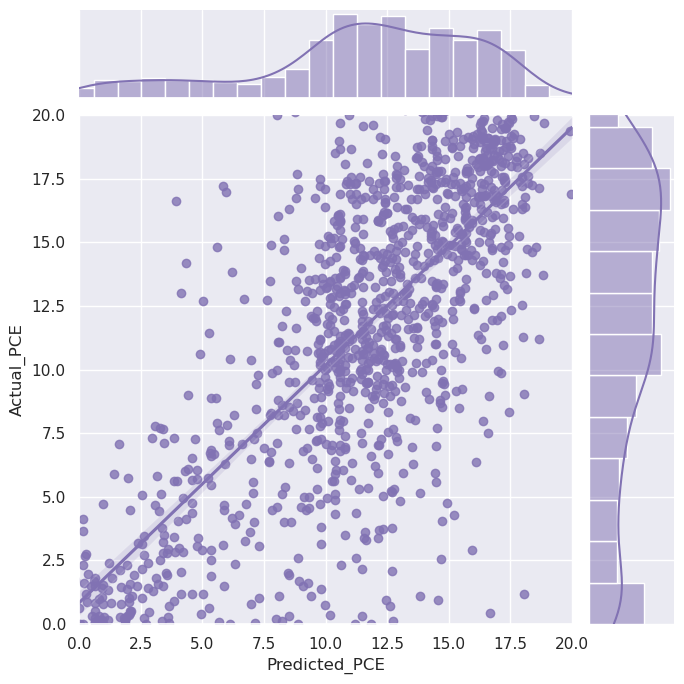

In [154]:
import seaborn as sns
sns.set_theme(style="darkgrid")

eval_data = pd.DataFrame({
    'Predicted_PCE': y_pred,
    'Actual_PCE': y_test
})

g = sns.jointplot(x="Predicted_PCE", y="Actual_PCE", data=eval_data,
                  kind="reg", truncate=False,
                  xlim=(0, 20), ylim=(0, 12),
                  color="m", height=7)

In [182]:
print(type(y_test))

<class 'pandas.core.series.Series'>


# Bayesian Optimization for Hyperparameters in XGBoost

In [195]:
from hyperopt import fmin, tpe, hp, STATUS_OK

# space = {
#     'max_depth': hp.quniform('max_depth', 2, 32, 1),
#     'learning_rate': hp.loguniform('learning_rate', -5, -2),
#     'subsample': hp.uniform('subsample', 0.5, 1)
# }

space = {
    'max_depth': hp.quniform('max_depth', 2, 32, 1),
    'learning_rate': hp.loguniform('learning_rate', -6, -1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'gamma': hp.uniform('gamma', 0, 5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

def objective(params):
    xgb_model = XGBRegressor(
        max_depth=int(params['max_depth']),  # Ensure max_depth is an integer
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        n_estimators=int(params['n_estimators']),  # Ensure n_estimators is an integer
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree']
    )
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = mean_absolute_error(y_test, y_pred)
    return {'loss': score, 'status': STATUS_OK}

best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 100/100 [21:04:55<00:00, 758.96s/trial, best loss: 2.818788301165285]   
Best set of hyperparameters:  {'colsample_bytree': 0.5682614956521421, 'gamma': 3.1898711558058657, 'learning_rate': 0.009785766924919498, 'max_depth': 20.0, 'n_estimators': 600.0, 'subsample': 0.669097735381701}


# Training with optimal values
best_params = {
    'learning_rate': 0.037580732411128234,
    'max_depth': 16,
    'subsample': 0.7092227823999635
}

Mean Absolute Error (MAE): 2.873
Mean Squared Error (MSE): 15.159
R^2 Score: 0.541

{'colsample_bytree': 0.5682614956521421,
               'gamma': 3.1898711558058657,
               'learning_rate': 0.009785766924919498,
               'max_depth': 20,
               'n_estimators': 600,
               'subsample': 0.669097735381701}
               


In [198]:
best_params = {'colsample_bytree': 0.5682614956521421,
               'gamma': 3.1898711558058657,
               'learning_rate': 0.009785766924919498,
               'max_depth': 20,
               'n_estimators': 600,
               'subsample': 0.669097735381701}

optim_model = XGBRegressor(**best_params)

# Train the model
optim_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = optim_model.predict(X_test)

# Evaluate the model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error (MAE): 2.819
Mean Squared Error (MSE): 14.354
R^2 Score: 0.565


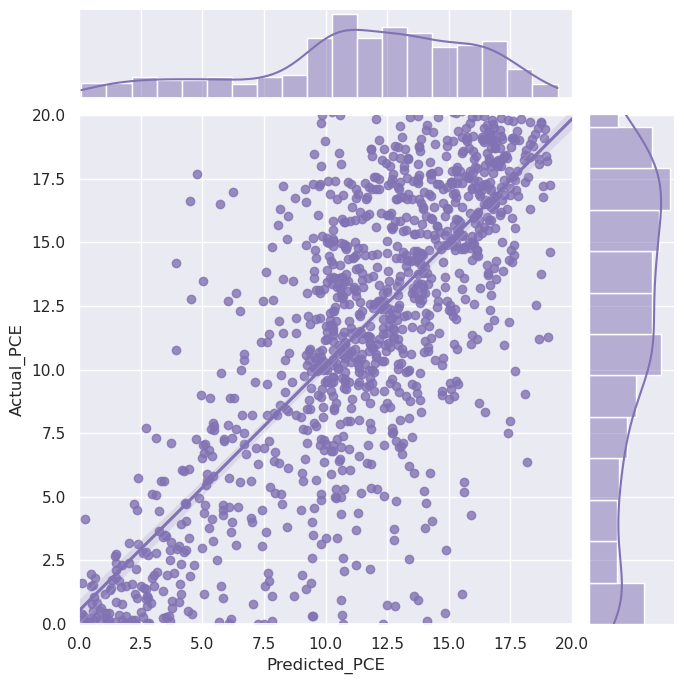

In [200]:
import seaborn as sns
sns.set_theme(style="darkgrid")

eval_data = pd.DataFrame({
    'Predicted_PCE': y_pred,
    'Actual_PCE': y_test
})

g = sns.jointplot(x="Predicted_PCE", y="Actual_PCE", data=eval_data,
                  kind="reg", truncate=False,
                  xlim=(0, 20), ylim=(0, 20),
                  color="m", height=7)

In [ ]:
# Future: use XGBoost with DescriptorCalculator to featurize molecules rather than fingerprints